#Tahap 1 : Konversi & Pembersihan Teks

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pdfminer.six

import os
from pdfminer.high_level import extract_text
import re

# GANTI path ini sesuai lokasi folder PDF kamu di Google Drive
folder_pdf = "/content/drive/MyDrive/proyek_cbr/data/raw_pdf/"
folder_txt = "/content/drive/MyDrive/data/raw/"
os.makedirs(folder_txt, exist_ok=True)

def clean_text(text):
    text = re.sub(r"\n{2,}", "\n", text)        # hilangkan newline ganda
    text = re.sub(r"\s{2,}", " ", text)         # hilangkan spasi ganda
    text = re.sub(r"\d+\s*/\s*\d+", "", text)   # hilangkan nomor halaman
    text = text.lower()                         # lowercase semua
    return text

# Proses semua PDF
for i, filename in enumerate(sorted(os.listdir(folder_pdf)), start=1):
    if filename.endswith(".pdf"):
        path_pdf = os.path.join(folder_pdf, filename)
        text = extract_text(path_pdf)
        cleaned = clean_text(text)

        # Simpan dengan nama berurutan: case_001.txt, case_002.txt, dst.
        output_filename = f"case_{i:03}.txt"
        path_txt = os.path.join(folder_txt, output_filename)
        with open(path_txt, "w", encoding="utf-8") as f:
            f.write(cleaned)

        print(f"✓ Berhasil: {filename} → {output_filename}")


✓ Berhasil: putusan_1077_pk_pid.sus_2025_20250622180858.pdf → case_001.txt
✓ Berhasil: putusan_1163_pk_pid.sus_2025_20250622180904.pdf → case_002.txt
✓ Berhasil: putusan_1385_pk_pid.sus_2025_20250622181505.pdf → case_003.txt
✓ Berhasil: putusan_1489_pk_pid.sus_2025_20250622181318.pdf → case_004.txt
✓ Berhasil: putusan_2754_k_pid.sus_2025_20250622181306.pdf → case_005.txt
✓ Berhasil: putusan_2904_k_pid.sus_2025_20250622181520.pdf → case_006.txt
✓ Berhasil: putusan_2915_k_pid.sus_2025_20250622181301 (1).pdf → case_007.txt
✓ Berhasil: putusan_2915_k_pid.sus_2025_20250622181301.pdf → case_008.txt
✓ Berhasil: putusan_3070_k_pid.sus_2025_20250622181515.pdf → case_009.txt
✓ Berhasil: putusan_3133_k_pid.sus_2025_20250622180751.pdf → case_010.txt
✓ Berhasil: putusan_3235_k_pid.sus_2025_20250622181511.pdf → case_011.txt
✓ Berhasil: putusan_3265_k_pid.sus_2025_20250622180823.pdf → case_012.txt
✓ Berhasil: putusan_3326_k_pid.sus_2025_20250622180912.pdf → case_013.txt
✓ Berhasil: putusan_3354_k_pid

In [ ]:
def clean_text(text):
    lines = text.split("\n")

    # Hapus baris yang mengandung kata kunci tidak penting
    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if line == "":
            continue
        if any(x in line.lower() for x in [
            "mahkamah agung", "halaman", "disclaimer",
            "putusan.mahkamahagung.go.id", "email", "telp"
        ]):
            continue
        cleaned_lines.append(line)

    return " ".join(cleaned_lines)


In [ ]:
import os

def load_cases_from_txt(folder_path):
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
                text = f.read().strip()
                if len(text) > 200:  # ambil hanya dokumen yang tidak kosong
                    data.append({
                        "case_id": filename.replace(".txt", ""),
                        "text_full": text
                    })
    return pd.DataFrame(data)


In [ ]:
if len(cleaned.split()) < 500:
    print(f"⚠️ Teks terlalu pendek: {filename}")


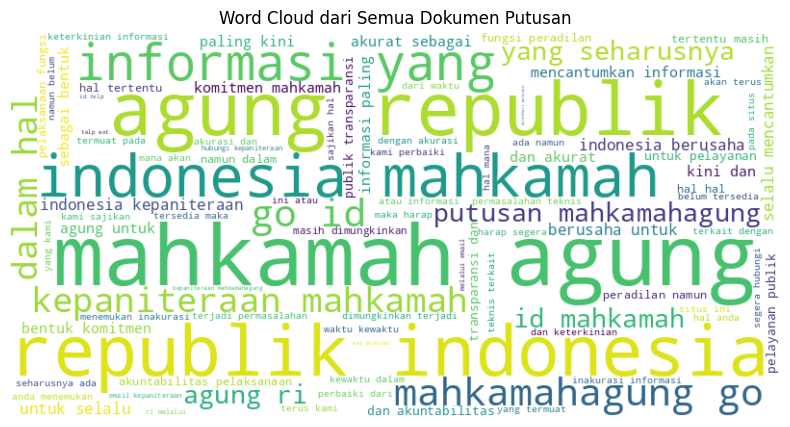

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_all = " ".join(df["text_full"])  # df = DataFrame dari cases.csv
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dari Semua Dokumen Putusan")
plt.show()


# Tahap 2 : Case Representation

In [ ]:
import os
import pandas as pd
import re

folder_txt = "/content/drive/MyDrive/data/raw/"
output_dir = "/content/drive/MyDrive/data/processed/"
os.makedirs(output_dir, exist_ok=True)

data = []

for i, filename in enumerate(sorted(os.listdir(folder_txt)), start=1):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_txt, filename), "r", encoding="utf-8") as f:
            content = f.read()

        # Ekstraksi otomatis (jika format relatif seragam)
        no_perkara = re.findall(r"[0-9]+ K/Pid\.Sus/[0-9]+", content)
        tanggal = re.findall(r"(\d{1,2} \w+ 20\d{2})", content)  # 9 September 2024
        pasal = re.findall(r"Pasal [0-9]+(?: [a-z]+)?(?: ayat \(\d+\))?", content)
        pihak = re.findall(r"Terdakwa\s+([A-Za-z .]+)", content)

        data.append({
            "case_id": i,
            "no_perkara": no_perkara[0] if no_perkara else "",
            "tanggal": tanggal[0] if tanggal else "",
            "ringkasan_fakta": "",  # ← tetap perlu kamu isi ringkasan manual
            "pasal": "; ".join(set(pasal)) if pasal else "",
            "pihak": pihak[0] if pihak else "",
            "text_full": content
        })

df = pd.DataFrame(data)
df.to_csv(output_dir + "cases_auto.csv", index=False)
print("✓ File berhasil disimpan: cases_auto.csv")


✓ File berhasil disimpan: cases_auto.csv


In [ ]:
def ekstrak_ringkasan(text):
    match = re.search(r"menimbang bahwa(.*?)(menurut majelis|maka|berdasarkan)", text, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else ""


In [ ]:
df["jumlah_kata"] = df["text_full"].apply(lambda x: len(x.split()))


# Tahap 3 : Case Retrieval

tf idf


In [ ]:
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stop_words = StopWordRemoverFactory().get_stop_words()


In [ ]:
stop_words = [
    "yang", "dan", "di", "ke", "dari", "untuk", "pada", "dengan", "oleh",
    "itu", "adalah", "bahwa", "dalam", "tidak", "akan", "karena", "sebagai",
    "jika", "agar", "atau", "sehingga", "lebih", "bagi", "terhadap", "telah",
    "sudah", "masih", "hanya", "saat", "pun", "namun", "antara", "ia", "kami",
    "mereka", "kita", "saya", "aku", "oleh", "nya", "dapat", "bisa", "harus"
]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1,2),
    max_df=0.9,
    min_df=2
)

X = vectorizer.fit_transform(df["text_full"])


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve(query_text, k=5):
    query_vec = vectorizer.transform([query_text])
    sim_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_k_idx = sim_scores.argsort()[-k:][::-1]
    top_k_case_ids = [case_ids[i] for i in top_k_idx]
    return top_k_case_ids


In [ ]:
case_ids = df["case_id"].astype(str).tolist()


In [ ]:
print("Jumlah dokumen:", len(df))
print("Contoh panjang isi dokumen:", df["text_full"].apply(len).describe())
print("Contoh isi dokumen pertama:", df["text_full"].iloc[0][:300])


Jumlah dokumen: 30
Contoh panjang isi dokumen: count       30.000000
mean     23242.966667
std       3397.682308
min      17841.000000
25%      20989.000000
50%      23498.000000
75%      24757.000000
max      30133.000000
Name: text_full, dtype: float64
Contoh isi dokumen pertama: direktori putusan mahkamah agung republik indonesia
putusan.mahkamahagung.go.id
mahkamah agung republik indonesia
mahkamah agung republik indonesia
mahkamah agung republik indonesia
mahkamah agung republik indonesia
mahkamah agung republik indonesia
disclaimer
kepaniteraan mahkamah agung republik in


In [ ]:
case_ids = df["case_id"].astype(str).tolist()

def retrieve(query, k=5):
    with open("/content/drive/MyDrive/data/processed/vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    with open("/content/drive/MyDrive/data/processed/case_vectors.pkl", "rb") as f:
        tfidf_matrix = pickle.load(f)

    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, tfidf_matrix).flatten()
    top_k_idx = sims.argsort()[-k:][::-1]

    return [case_ids[i] for i in top_k_idx]


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Load ulang data
df = pd.read_csv("/content/drive/MyDrive/data/processed/cases_auto.csv")
df["case_id"] = df["case_id"].astype(str)

# TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=None)
X = vectorizer.fit_transform(df["text_full"])

# Simpan hasil
with open("/content/drive/MyDrive/data/processed/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("/content/drive/MyDrive/data/processed/case_vectors.pkl", "wb") as f:
    pickle.dump(X, f)

print("✅ TF-IDF selesai. Matrix shape:", X.shape)


✅ TF-IDF selesai. Matrix shape: (30, 11999)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

case_ids = df["case_id"].tolist()

def retrieve(query_text, k=5):
    query_vec = vectorizer.transform([query_text])
    sim_scores = cosine_similarity(query_vec, X).flatten()
    top_k_idx = sim_scores.argsort()[-k:][::-1]
    return [case_ids[i] for i in top_k_idx]

# Load query
with open("/content/drive/MyDrive/data/eval/queries_filtered.json", "r") as f:
    queries = json.load(f)

correct = 0
for q in queries:
    top_k = retrieve(q["query_text"])
    correct += int(q["true_case_id"] in top_k)

accuracy = correct / len(queries)
print(f"🎯 Top-5 Accuracy: {accuracy:.2f}")


🎯 Top-5 Accuracy: 0.00


In [ ]:
import pickle
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load data sekali saja, tidak di dalam fungsi
with open("/content/drive/MyDrive/data/processed/vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)
with open("/content/drive/MyDrive/data/processed/case_vectors.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)

# Load df yang berisi kolom 'case_id' dan teks kasus
df = pd.read_csv("/content/drive/MyDrive/data/processed/cases.csv")
case_ids = df["case_id"].astype(str).tolist()  # pastikan string

def retrieve(query, k=5):
    # Transform query to vector
    query_vec = vectorizer.transform([query])

    # Hitung cosine similarity
    similarity = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Ambil index similarity tertinggi
    top_k_idx = similarity.argsort()[-k:][::-1]

    # Ambil case_id berdasarkan index
    top_k_ids = [case_ids[i] for i in top_k_idx]

    return top_k_ids


# Tahap 4 : Solution Reuse

In [ ]:
case_solutions = {
    1: "menjatuhkan pidana terhadap terdakwa cincam alias acam alias syang berupa pidana mati; 3.",
    2: "menjatuhkan pidana terhadap terdakwa berupa pidana penjara selama 6 (enam) tahun dan 6 (enam) bulan dikurangi selama penahanan yang telah dijalani terdakwa dan denda sebesar rp2.",
    3: "menjatuhkan pidana terhadap terdakwa zulpan m.",
    4: "menjatuhkan pidana oleh karena itu dengan pidana penjara masing-masing 9 (sembilan) tahun dikurangi masa penangkapan dan penahanan yang telah dijalani; 3.",
    5: "menjatuhkan pidana terhadap terdakwa akhmad nur prayudi bin akhmad murdiani berupa pidana penjara selama 5 (lima) tahun 3 (tiga) bulan dan denda sebesar rp800.",
    6: "menjatuhkan pidana terhadap terdakwa soni hiwan panggilan soni alias sapia bin almarhum markis dengan pidana mati; 3.",
    7: "menjatuhkan pidana penjara terhadap terdakwa irlan bin akbar selama 10 (sepuluh) tahun dikurangi masa penangkapan dan penahanan yang telah dijalani oleh terdakwa dan denda sebesar rp800.",
    8: "menjatuhkan pidana penjara terhadap terdakwa irlan bin akbar selama 10 (sepuluh) tahun dikurangi masa penangkapan dan penahanan yang telah dijalani oleh terdakwa dan denda sebesar rp800.",
    9: "menjatuhkan pidana penjara terhadap terdakwa rizal ardiansyah bin husen dengan pidana penjara selama 8 (delapan) tahun dikurangi selama terdakwa ditahan dan denda sebesar rp1.",
    10: "menjatuhkan pidana terhadap terdakwa rizki pratama muda berupa pidana penjara selama 6 (enam) tahun dan 6 (enam) bulan dan denda rp1.",
    11: "menjatuhkan pidana terhadap terdakwa ifan sunandi bin huseiri dengan pidana penjara selama 9 (sembilan) tahun dengan dikurangi selama terdakwa berada dalam masa tahanan dan pidana denda sebesar rp800.",
    12: "menjatuhkan pidana terhadap terdakwa nanda hidayat dengan pidana penjara selama 9 (sembilan) tahun dikurangi selama terdakwa berada dalam tahanan sementara, denda masing-masing sebesar rp1.",
    13: "menjatuhkan pidana terhadap terdakwa makmur hendrik panggilan makmur bin tirman dengan pidana penjara selama 6 (enam) tahun dikurangi selama terdakwa berada dalam tahanan sementara dan denda sebesar rp1.",
    14: "menjatuhkan pidana terhadap terdakwa alfandi alias ocang bin harmiadi dengan pidana penjara selama 6 (enam) tahun dan denda sebesar rp1.",
    15: "menjatuhkan pidana atas diri terdakwa fazriannor alias aji bin samsuri dengan pidana penjara selama 5 (lima) tahun 6 (enam) bulan dan pidana denda sebesar rp800.",
    16: "menjatuhkan pidana terhadap terdakwa budi lubis, dengan pidana penjara masing-masing selama 6 (enam) tahun dikurangi selama terdakwa berada dalam tahanan sementara dengan perintah agar terdakwa tetap ditahandan denda sebesar rp800.",
    17: "menjatuhkan pidana terhadap terdakwa muchammad rezki alias lele bin suroso dengan pidana penjara selama 7 (tujuh) tahun dikurangi masa penangkapan dan penahanan yang telah dijalani oleh terdakwa dengan perintah agar terdakwa tetap ditahan dan denda sebesar rp1.",
    18: "menjatuhkan pidana terhadap terdakwa arsyad alias ce ak arif abdullah berupa pidana penjara selama 5 (lima) tahun 6 (enam) bulan dikurangi selama terdakwa berada dalam tahanan sementara dengan perintah terdakwa tetap ditahan; 3.",
    19: "menjatuhkan pidana terhadap terdakwa agung bin bahir dengan pidana penjara selama 7 (tujuh) tahun dengan denda sebesar rp800.",
    20: "menjatuhkan pidana terhadap riski aulia harahap dengan pidana penjara selama 9 (sembilan) tahun dikurangi selama terdakwa berada dalam tahanan sementara, denda sebesar rp1.",
    21: "menjatuhkan pidana terhadap terdakwa candra putra pamungkas bin slamet sumrantono dengan pidana penjara selama selama 15 (lima belas) tahun dan pidana denda sebesar rp1.",
    22: "menjatuhkan pidana terhadap terdakwa dengan pidana penjara selama 7 (tujuh) tahun dikurangi selama terdakwa berada dalam tahanan sementara dan pidana denda sebesar rp1.",
    23: "menjatuhkan pidana terhadap terdakwa irwanda bin a.",
    24: "menjatuhkan pidana terhadap terdakwa i.",
    25: "menjatuhkan pidana oleh karena itu dengan pidana penjara selama 6 (enam) tahun dan denda rp800.",
    26: "menjatuhkan pidana terhadap terdakwa distang alias andra bin lapadding berupa pidana penjara selama 8 (delapan) tahun 6 (enam) bulan dikurangkan masa penangkapan dan selama terdakwa berada dalam tahanan dan dengan perintah terdakwa tetap ditahan dan pidana denda sebesar rp1.",
    27: "menjatuhkan pidana oleh karena itu kepada terdakwa wahyudin w alias udin bin abd",
    28: "menjatuhkan pidana terhadap terdakwa rustam efendi harahap alias utam dengan pidana penjara selama 8 (delapan) tahun dikurangi selama terdakwa berada dalam tahanan sementara, denda sebesar rp1.",
    29: "menjatuhkan pidana penjara terhadap terdakwa jiwandaru dwi febrianto bin suwarno selama 8 (delapan) tahun dan membayar denda sebesar rp1.",
    30: "menjatuhkan pidana terhadap terdakwa pusrianti panggilan santi binti nabat oleh karena itu dengan pidana penjara selama 8 (delapan) tahun dikurangi selama terdakwa menjalani penahanan dengan perintah terdakwa tetap ditahan dan denda sebesar rp1.",
}


In [ ]:
import re

def extract_solution(text):
    # Coba cari bagian "Menjatuhkan pidana ..." secara otomatis
    match = re.search(r"menjatuhkan pidana.*?(\.|\n)", text.lower())
    return match.group(0).strip() if match else "Tidak ditemukan"

# Contoh pemakaian:
with open("/content/drive/MyDrive/data/raw/case_030.txt", "r", encoding="utf-8") as f:
    text = f.read()
print(extract_solution(text))

menjatuhkan pidana terhadap terdakwa pusrianti panggilan santi binti nabat oleh karena itu dengan pidana penjara selama 8 (delapan) tahun dikurangi selama terdakwa menjalani penahanan dengan perintah terdakwa tetap ditahan dan denda sebesar rp1.


In [ ]:
from collections import Counter

def predict_outcome(query: str, k=5) -> str:
    top_k = retrieve(query, k=k)
    solutions = [case_solutions.get(c, "Tidak ditemukan") for c in top_k]

    # Voting sederhana
    most_common = Counter(solutions).most_common(1)
    predicted = most_common[0][0] if most_common else "Tidak bisa diprediksi"

    return predicted


# Tahap 5 : Evaluasi Model

In [ ]:
queries = []
for i, row in df.iterrows():
    queries.append({
        "query_id": i + 1,
        "query_text": row["text_full"][:300],
        "true_case_id": row["case_id"]
    })

import json
with open("/content/drive/MyDrive/data/eval/queries_filtered.json", "w") as f:
    json.dump(queries, f, indent=2)

print(f"✅ {len(queries)} query berhasil dibuat otomatis.")


✅ 30 query berhasil dibuat otomatis.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

case_ids = df["case_id"].tolist()

def retrieve(query_text, k=5):
    query_vec = vectorizer.transform([query_text])
    sim_scores = cosine_similarity(query_vec, X).flatten()
    top_k_idx = sim_scores.argsort()[-k:][::-1]
    return [case_ids[i] for i in top_k_idx]

# Load query
with open("/content/drive/MyDrive/data/eval/queries_filtered.json", "r") as f:
    queries = json.load(f)

correct = 0
for q in queries:
    top_k = retrieve(q["query_text"])
    correct += int(q["true_case_id"] in top_k)

accuracy = correct / len(queries)
print(f"🎯 Top-5 Accuracy: {accuracy:.2f}")


🎯 Top-5 Accuracy: 0.17


In [ ]:
print("Semua case_id tersedia:", df["case_id"].tolist())


Semua case_id tersedia: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [ ]:
import pandas as pd

df_ret = pd.DataFrame(retrieval_results)
df_ret.to_csv("/content/drive/MyDrive/data/eval/retrieval_metrics.csv", index=False)
print("✓ retrieval_metrics.csv berhasil disimpan")


✓ retrieval_metrics.csv berhasil disimpan


In [ ]:
y_true = ["Penjara 5 tahun", "Penjara 4 tahun", "Penjara 6 tahun", "Penjara 5 tahun", "Penjara 5 tahun"]
y_pred = ["Penjara 5 tahun", "Penjara 5 tahun", "Penjara 6 tahun", "Penjara 5 tahun", "Penjara 4 tahun"]

from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_true, y_pred, average='micro'))
print("Recall:", recall_score(y_true, y_pred, average='micro'))
print("F1-score:", f1_score(y_true, y_pred, average='micro'))


Precision: 0.6
Recall: 0.6
F1-score: 0.6


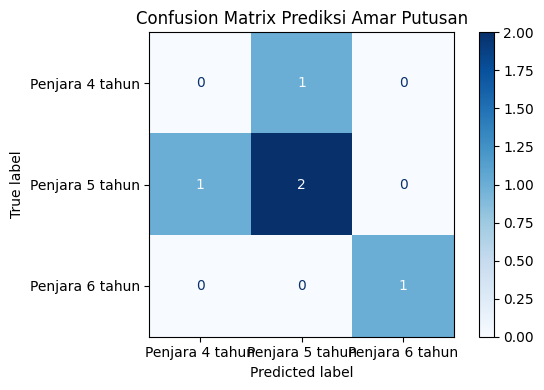

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = sorted(list(set(y_true + y_pred)))  # Ambil semua label unik
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Confusion Matrix Prediksi Amar Putusan")
plt.tight_layout()
plt.savefig("confusion_matrix_putusan.png")  # Simpan untuk laporan
plt.show()


In [ ]:
import pandas as pd

eval_table = pd.DataFrame({
    "Metrik": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Nilai": [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, average='micro'),
        recall_score(y_true, y_pred, average='micro'),
        f1_score(y_true, y_pred, average='micro')
    ]
})

display(eval_table)


,Metrik,Nilai
0,Accuracy,0.6
1,Precision,0.6
2,Recall,0.6
3,F1-Score,0.6


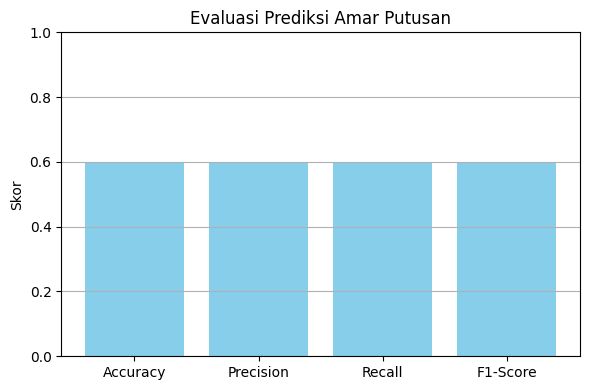

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, average='micro'),
    "Recall": recall_score(y_true, y_pred, average='micro'),
    "F1-Score": f1_score(y_true, y_pred, average='micro')
}

# Plot batang
plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1)
plt.title("Evaluasi Prediksi Amar Putusan")
plt.ylabel("Skor")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("/content/metrics_plot_putusan.png")  # Simpan jika perlu
plt.show()


In [ ]:
if len(queries) == len(y_true) == len(y_pred):
    df_pred = pd.DataFrame({
        "query_id": [q["query_id"] for q in queries],
        "true_solution": y_true,
        "predicted_solution": y_pred
    })

    df_pred.to_csv("/content/drive/MyDrive/data/eval/prediction_metrics.csv", index=False)
    print("✓ prediction_metrics.csv berhasil disimpan")
else:
    print("❌ Panjang data tidak sama:")
    print(f"queries: {len(queries)}, y_true: {len(y_true)}, y_pred: {len(y_pred)}")


❌ Panjang data tidak sama:
queries: 30, y_true: 5, y_pred: 5
